<div class="alert alert-block alert-info">
Section of the book chapter: <b>5.2.2 Active Learning</b>
</div>

# 4. Active learning

**Table of Contents**

* [4.1 Active Learning Setup](#4.1-Active-Learning-Setup)
* [4.2 Initial Estimation](#4.2-Initial-Estimation)
* [4.3 Including Active Learning](#4.3-Including-Active-Learning)

**Learnings:**

- how to implement basic active learning approaches models,
- how active learning can improve estimations.



### Packages

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
from modAL.models import ActiveLearner

import utils

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Read in Data

**Dataset:** Felix M. Riese and Sina Keller, "Hyperspectral benchmark dataset on soil moisture", Dataset, Zenodo, 2018. [DOI:10.5281/zenodo.1227836](http://doi.org/10.5281/zenodo.1227836) and [GitHub](https://github.com/felixriese/hyperspectral-soilmoisture-dataset)

**Introducing paper:** Felix M. Riese and Sina Keller, “Introducing a Framework of Self-Organizing Maps for Regression of Soil Moisture with Hyperspectral Data,” in IGARSS 2018 - 2018 IEEE International Geoscience and Remote Sensing Symposium, Valencia, Spain, 2018, pp. 6151-6154. [DOI:10.1109/IGARSS.2018.8517812](https://doi.org/10.1109/IGARSS.2018.8517812)

In [2]:
X_train, X_test, y_train, y_test, y_train_full = utils.get_xy_split(missing_rate=0.8)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, y_train_full.shape)
print(y_train[y_train>=0.].shape, y_test[y_test>=0.].shape, y_train_full[y_train>=0.].shape)

(339, 125) (340, 125) (339,) (340,) (339,)
(68,) (340,) (68,)


In [3]:
index_initial = np.where(y_train>=0.)[0]

***

## 4.1 Active Learning Setup
Source: [modAL/active_regression.py](https://github.com/modAL-python/modAL/blob/master/examples/active_regression.py)

In [4]:
# defining the kernel for the Gaussian process
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

In [5]:
# query strategy for regression
def regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    query_idx = np.argmax(std)
    return query_idx, X[query_idx]

In [6]:
# initializing the active learner
regressor = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=kernel),
    query_strategy=regression_std,
    X_training=X_train[index_initial],
    y_training=y_train[index_initial])

print(X_train[index_initial].shape, y_train[index_initial].shape)

(68, 125) (68,)


***

## 4.2 Initial Estimation

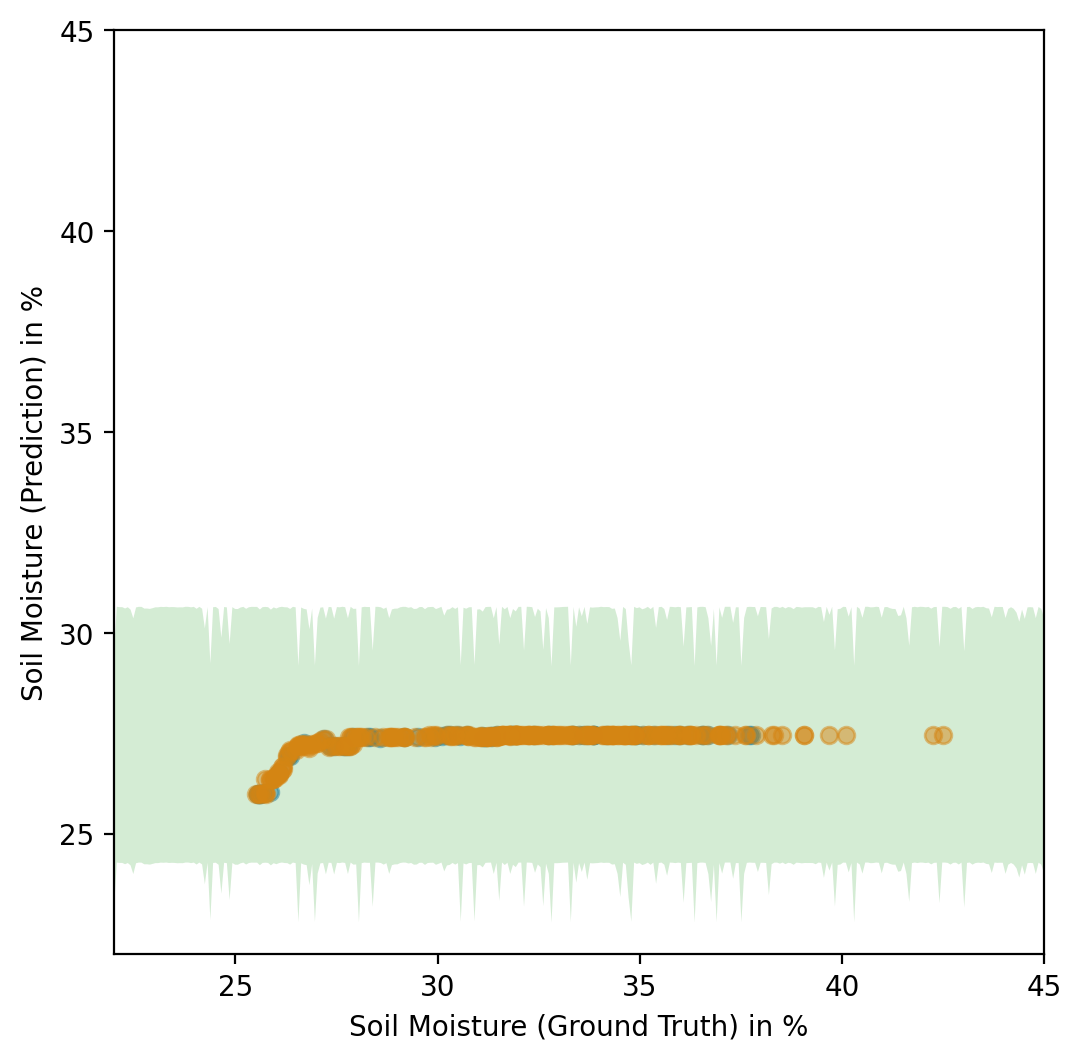

In [7]:
# plot initial estimation
plt.figure(figsize=(6,6))
pred, std = regressor.predict(X_train, return_std=True)

# plot prediction of supervised samples
plt.scatter(y_train_full[index_initial], pred[index_initial], alpha=0.5)

# plot prediction of unsupervised samples
not_initial = [i for i in range(y_train.shape[0]) if i not in index_initial]
plt.scatter(y_train_full[not_initial], pred[not_initial], alpha=0.5)

# plot std
plt.fill_between(np.linspace(22, 45, 339), pred-std, pred+std, alpha=0.2)

plt.xlim(22.0, 45.0)
plt.ylim(22.0, 45.0)
plt.xlabel("Soil Moisture (Ground Truth) in %")
plt.ylabel("Soil Moisture (Prediction) in %")
plt.show()

***

## 4.3 Including Active Learning

In [8]:
n_queries = 150
for idx in range(n_queries):
    query_idx, query_instance = regressor.query(X_train)
    # print(query_idx, query_instance)
    # print(X_train[query_idx].reshape(1,125).shape)
    # print(y_train_full[query_idx].reshape(-1, ).shape)
    regressor.teach(X_train[query_idx].reshape(1, 125), y_train_full[query_idx].reshape(-1, ))

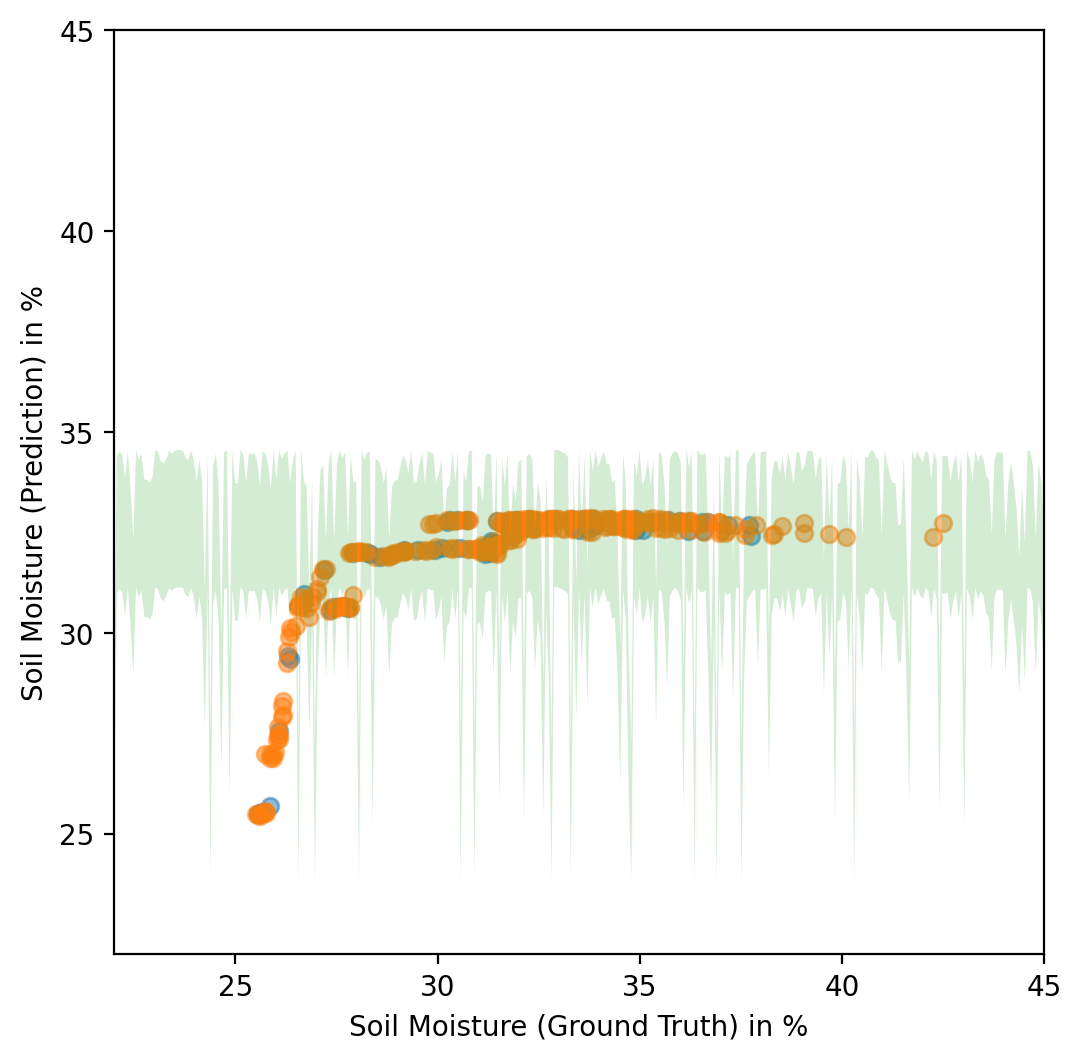

In [9]:
# plot initial estimation
plt.figure(figsize=(6,6))
pred, std = regressor.predict(X_train, return_std=True)

# plot prediction of supervised samples
plt.scatter(y_train_full[index_initial], pred[index_initial], alpha=0.5)

# plot prediction of unsupervised samples
not_initial = [i for i in range(y_train.shape[0]) if i not in index_initial]
plt.scatter(y_train_full[not_initial], pred[not_initial], alpha=0.5)

# plot std
plt.fill_between(np.linspace(22, 45, 339), pred-std, pred+std, alpha=0.2)

plt.xlim(22.0, 45.0)
plt.ylim(22.0, 45.0)
plt.xlabel("Soil Moisture (Ground Truth) in %")
plt.ylabel("Soil Moisture (Prediction) in %")
plt.show()